In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Thu Feb  2 16:42:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [4]:
%cd /mydrive/X-Rays/

/content/gdrive/My Drive/X-Rays


In [6]:
# Import the required libraries
import os
import numpy as np
import pandas as pd
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg16 import preprocess_input
#from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.applications.densenet import preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import csv

In [7]:
# Load the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add the output layer
x = Flatten()(base_model.output)
x = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


80134624/80134624 [==============================] - 0s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
# Load the training data
train_data = []
train_labels = []

# Load the training data from the excel file
df = pd.read_csv('/content/gdrive/My Drive/X-Rays/dataset/labels_train.csv')

# Load the images and their labels
for i, row in df.iterrows():
    filename = row['file_name']
    class_id = row['class_id']

    img = image.load_img('/content/gdrive/My Drive/X-Rays/dataset/train_images/train_images/' + filename, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    train_data.append(x)
    train_labels.append(class_id)

In [9]:
# Convert the lists to numpy arrays
train_data = np.vstack(train_data)
train_labels = np.array(train_labels)

# One-hot encode the labels
train_labels = pd.get_dummies(train_labels).values

In [10]:
# Train the model
history = model.fit(train_data, train_labels, epochs=40, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])


Epoch 1/40
117/117 [==============================] - 15s 50ms/step - loss: 7.4359 - accuracy: 0.7324 - val_loss: 6.9718 - val_accuracy: 0.7102
Epoch 2/40
117/117 [==============================] - 4s 38ms/step - loss: 2.7753 - accuracy: 0.8451 - val_loss: 5.1959 - val_accuracy: 0.7583
Epoch 3/40
117/117 [==============================] - 4s 38ms/step - loss: 2.0354 - accuracy: 0.8812 - val_loss: 6.6413 - val_accuracy: 0.7583
Epoch 4/40
117/117 [==============================] - 4s 38ms/step - loss: 0.8369 - accuracy: 0.9326 - val_loss: 5.0394 - val_accuracy: 0.7733
Epoch 5/40
117/117 [==============================] - 4s 38ms/step - loss: 0.4014 - accuracy: 0.9599 - val_loss: 6.0469 - val_accuracy: 0.7455
Epoch 6/40
117/117 [==============================] - 4s 38ms/step - loss: 0.4822 - accuracy: 0.9540 - val_loss: 6.0061 - val_accuracy: 0.7711
Epoch 7/40
117/117 [==============================] - 4s 38ms/step - loss: 0.4214 - accuracy: 0.9617 - val_loss: 7.3296 - val_accuracy: 0.733

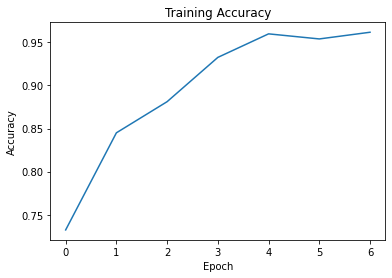

In [11]:
# Plot the training accuracy 
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
# Load the test data
test_data = []
for filename in os.listdir('/content/gdrive/My Drive/X-Rays/dataset/test_images/test_images/'):
    img = image.load_img('/content/gdrive/My Drive/X-Rays/dataset/test_images/test_images/' + filename, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    test_data.append(x)

# Convert the list to a numpy array
test_data = np.vstack(test_data)

# Make predictions on the test data
predictions = model.predict(test_data)

In [ ]:
predictions

In [ ]:
# Get the class ids for the predictions
class_ids = np.argmax(predictions, axis=1)

# Save the predictions to a csv file
with open('prediction.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["file_name", "class_id"])
    for i, filename in enumerate(os.listdir('/content/gdrive/My Drive/X-Rays/dataset/')):
        writer.writerow([filename, class_ids[i]])

In [ ]:
model.save(os.path.join('/content/gdrive/My Drive/X-Rays/dataset/models','vgg19.h5'))